In [17]:
import pandas as pd
import time
import seaborn as sns
import numpy as np
import os
from scattering_data import DataLoader
from vbi_elbo import MCElboMF, MCElboFG, correlation_from_covariance
import torch
import copy
import pickle as pkl
import matplotlib.pyplot as plt

# Plotting utilities

In [124]:
def specs(x, **kwargs):
    ax = sns.histplot(x=x)
    ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] + 10)
    ax.text(x.mean() - 3 * x.std(), kwargs["top"], f'{np.round(x.mean(),3)}' + r'$\pm$' + f'{np.round(x.std(),4)}')

# Loading Data

In [115]:
names = ["A0", "r0", "C1+^2", "P1+", "C1-^2", "P1-"]
data_train = DataLoader(4.342, "som")
print(data_train.data.shape)

(398, 4)


# Mean field fit and analysis

In [116]:
torch.manual_seed(2)

### Data 
x_train = torch.tensor(data_train.theta_cs)
y_train = torch.tensor(data_train.cs_data)

### torch.nn.Module class instance
nMC = 5
param_dim = 6
x_dim = 1
model = MCElboMF(nMC = nMC, x_dim = x_dim,
                 param_dim = param_dim,
                 f_dim = data_train.f_bounds.shape[0],
                 err_cs = data_train.err_cs,
                 Elab_cs = data_train.Elab_cs, f_sigmas = data_train.f_sigmas, recompute_values = True,
                 which_data = "som", barnard_Elab = None, l_som = data_train.l_som)

learning_rate = 5e-2
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
n_steps = 12000
# Saving intermediate results
loss_array = np.zeros(n_steps)
time_array = np.zeros(n_steps)
param_dictionary = {}
for name, param in model.named_parameters():
    param_dictionary[name] = []
    
startTime = time.time()
for t in range(n_steps):
    # Compute ELBO
    loss = - model.compute_elbo_loop(x_train, y_train)
    # Zero gradinets
    optimizer.zero_grad()
    # Compute gradients
    loss.backward()
    optimizer.step()
    
    # Utiliti computation
    loss_array[t] = loss.item()
    time_array[t] = time.time() - startTime 
    
    if t % 10 == 9: 
        for name, param in model.named_parameters():
            param_dictionary[name] = param_dictionary[name] + [param.detach().clone().numpy()]
    
    if t % 2000 == 1999:
        print(f"Loss: {loss.item()}, Step [{t}/{n_steps}]")
        print(model.ModelString())
        # Time estimmate
        print(f"Minutes remaining {(time.time() - startTime) * (n_steps - t) / (t * 60)}")

endTime = time.time()
print(endTime - startTime)

Loss: 2092.62939453125, Step [1999/12000]
theta mean: Parameter containing:
tensor([[ 5.8820e-02,  1.1371e+00,  1.4461e+01,  6.2723e-01,  1.2668e+01,
         -8.6117e-03,  9.6887e-01,  9.3869e-01,  1.1151e+00,  1.0940e+00,
          1.1475e+00,  1.1636e+00,  1.1712e+00,  1.2766e+00,  1.3983e+00]],
       dtype=torch.float64, requires_grad=True) 
 theta std tensor([[5.3774e-04, 1.6046e-02, 1.2422e+00, 2.9685e-01, 1.2970e+00, 5.1541e-01,
         5.4740e-03, 3.7432e-03, 3.0808e-03, 3.1548e-03, 2.8055e-03, 3.2068e-03,
         2.7450e-03, 4.0477e-03, 3.5347e-03]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
Minutes remaining 4.401436540329875
Loss: 529.4124145507812, Step [3999/12000]
theta mean: Parameter containing:
tensor([[ 0.0440,  1.2057, 15.8737,  1.5518, 13.5753,  0.8989,  0.9731,  0.9330,
          1.1013,  1.0431,  1.0685,  1.0587,  1.0674,  1.0864,  1.1691]],
       dtype=torch.float64, requires_grad=True) 
 theta std tensor([[1.9383e-04, 5.4746e-03, 4.5126e-01, 4

## Saving results

In [117]:
folder = "Outputs"
run_id = "som_mf_3_"

if not os.path.exists(folder):
    os.makedirs(folder)

dictionary_outputs = copy.deepcopy(param_dictionary)
dictionary_outputs["ELBO"] = -loss_array
dictionary_outputs["time"] = time_array
with open(folder + "/" + run_id + "outputs_" + "vars" + '.pickle', 'wb') as handle:
    pkl.dump(dictionary_outputs, handle, protocol=pkl.HIGHEST_PROTOCOL)

## Loading results

In [118]:
folder = "Outputs"
run_id = "som_mf_3_"

with open(folder + "/" + run_id + "outputs_" + "vars" + '.pickle', 'rb') as handle:
    dictionary_outputs = pkl.load(handle)
time_array = dictionary_outputs["time"]
loss_array = - dictionary_outputs["ELBO"]
param_dictionary = copy.deepcopy(dictionary_outputs)

## Fit plots

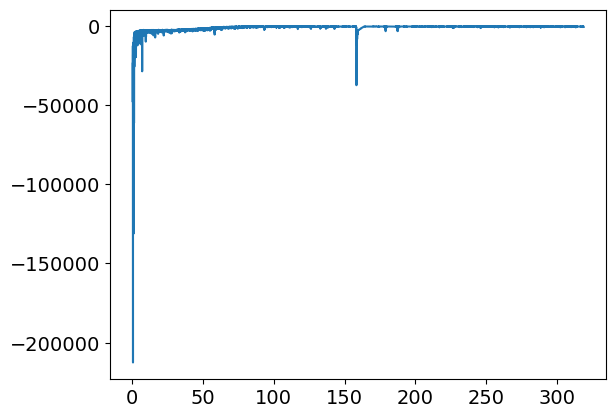

In [119]:
# ELBO
plt.plot(time_array[10:], -loss_array[10:])
plt.show()

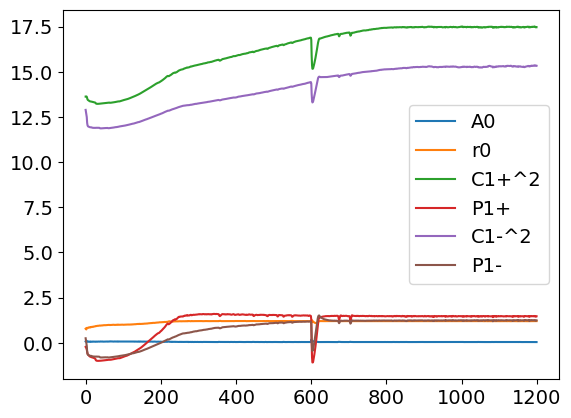

In [120]:
# Means
plt.plot(np.array(param_dictionary["q_theta_m"])[:,0,:6])
plt.legend(names)
plt.show()

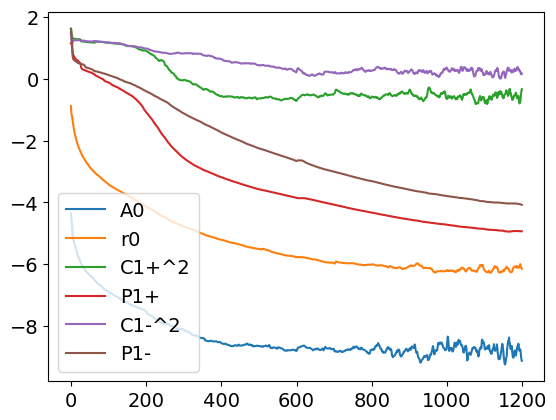

In [121]:
# SD
plt.plot(np.array(param_dictionary["q_theta_s"])[:,0,:6])
plt.legend(names)
plt.show()

### Posteriors

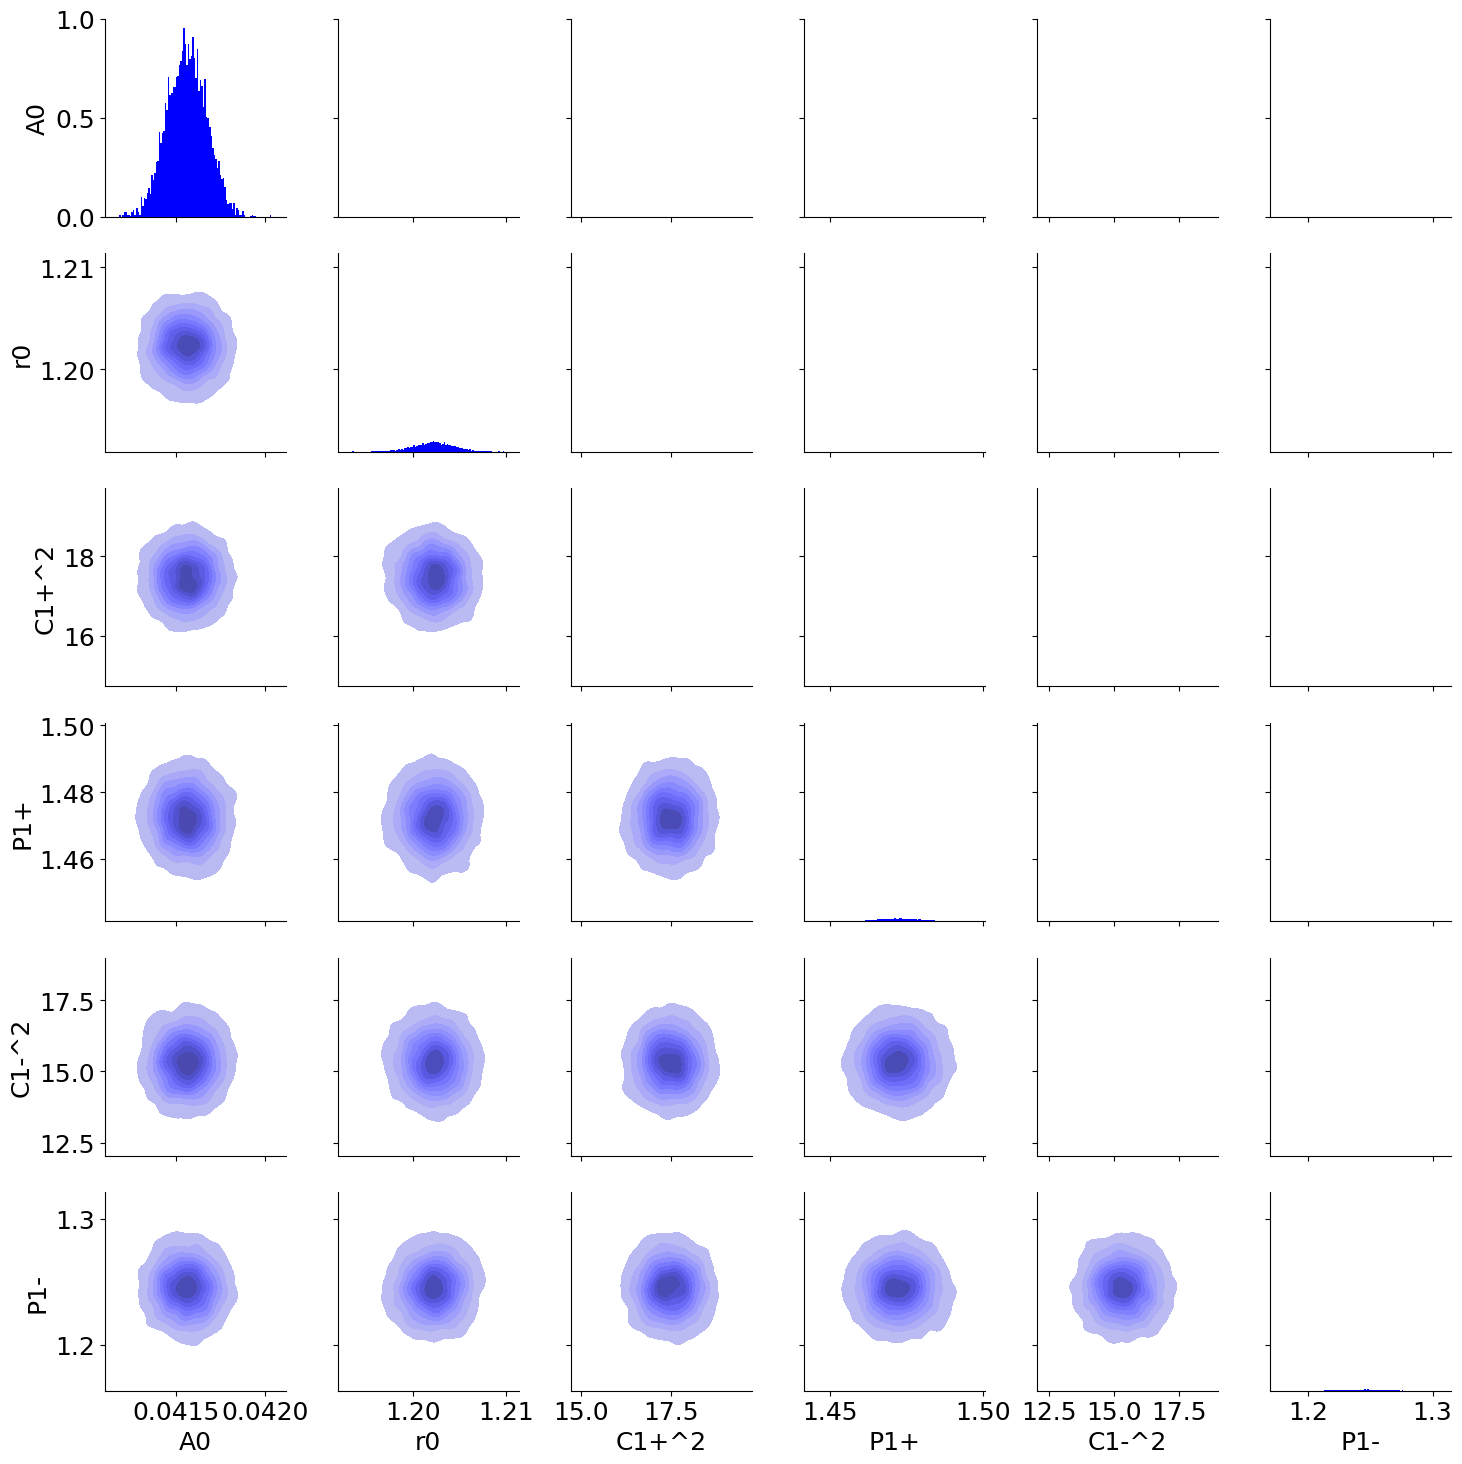

In [122]:
# VI Psoteriors
model.nMC = 5000
z = model.generate_sample(n_var = model.param_dim + model.f_dim)
theta = model.sample_reparam_normal(z, model.q_theta_m, model.q_theta_s)

alpha = 1
bins = 100
plt.rcParams.update({'font.size': 18})
samples = pd.DataFrame(theta.detach().numpy().reshape(model.nMC, model.param_dim +model.f_dim)[:,:6], columns = names)
g = sns.PairGrid(samples)
g.map_diag(plt.hist, bins = bins, alpha = alpha, color = "blue", density= True)
g.map_lower(sns.kdeplot, shade= True, thresh=0.05, color = "blue")
plt.show()

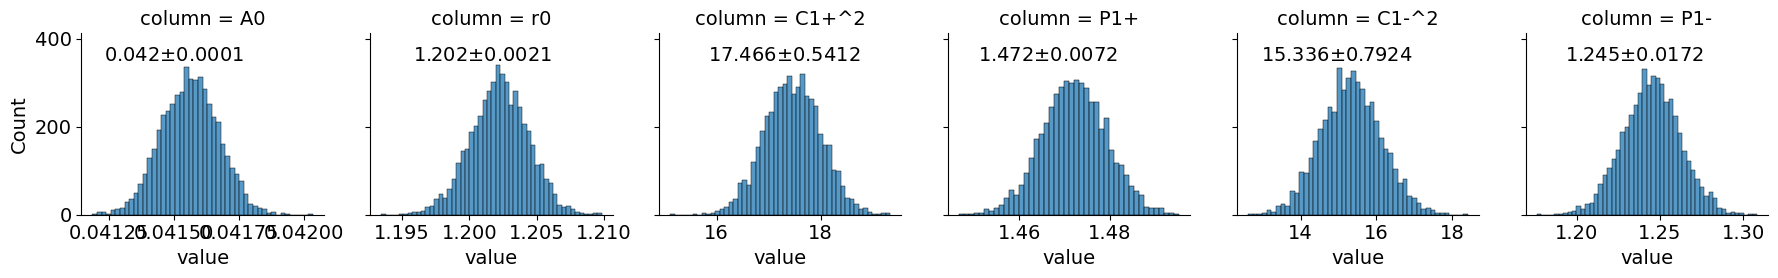

In [125]:
samples_melted = samples.melt(var_name='column')
plt.rcParams.update({'font.size': 14})
g = sns.FacetGrid(samples_melted, col='column', sharex=False)
g.map(specs, 'value', top  = 350)
plt.show()

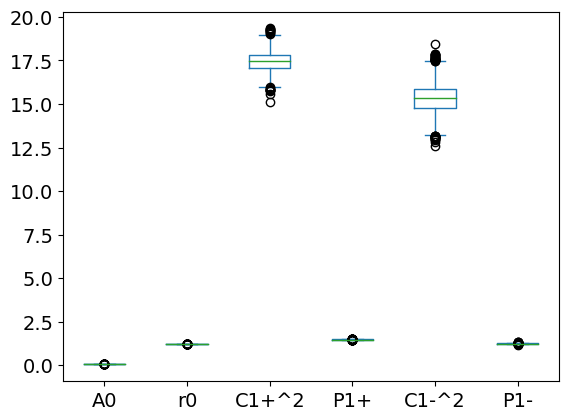

In [126]:
samples.plot(kind = "box")
plt.show()

# Full covariance fit and analysis

In [28]:
torch.manual_seed(2)

### Data 
x_train = torch.tensor(data_train.theta_cs)
y_train = torch.tensor(data_train.cs_data)

### torch.nn.Module class instance
nMC = 5
param_dim = 6
x_dim = 1

model = MCElboFG(nMC = nMC, x_dim = x_dim,
                 param_dim = param_dim,
                 f_dim = data_train.f_bounds.shape[0],
                 err_cs = data_train.err_cs,
                 Elab_cs = data_train.Elab_cs, f_sigmas = data_train.f_sigmas, recompute_values = True,
                 which_data = "som", barnard_Elab = None, l_som = data_train.l_som)

learning_rate = 5e-3
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
n_steps = 30000
# Saving intermediate results
loss_array = np.zeros(n_steps)
time_array = np.zeros(n_steps)
param_dictionary = {}
for name, param in model.named_parameters():
    param_dictionary[name] = []
    
startTime = time.time()
for t in range(n_steps):
    # Compute ELBO
    loss = - model.compute_elbo_loop(x_train, y_train)
    # Zero gradinets
    optimizer.zero_grad()
    # Compute gradients
    loss.backward()
    optimizer.step()
    
    # Utiliti computation
    loss_array[t] = loss.item()
    time_array[t] = time.time() - startTime 
    
    if t % 10 == 9: 
        for name, param in model.named_parameters():
            param_dictionary[name] = param_dictionary[name] + [param.detach().clone().numpy()]
    
    if t % 2000 == 1999:
        print(f"Loss: {loss.item()}, Step [{t}/{n_steps}]")
        print(model.ModelString())
        # Time estimmate
        print(f"Minutes remaining {(time.time() - startTime) * (n_steps - t) / (t * 60)}")

endTime = time.time()
print(endTime - startTime)

Loss: 6222.37109375, Step [1999/30000]
theta mean: Parameter containing:
tensor([[ 0.0474,  0.7402, 13.5075, -0.3122, 12.2935, -0.3000,  0.9779,  0.9364,
          1.0995,  1.0726,  1.1215,  1.1446,  1.1549,  1.2720,  1.4288]],
       dtype=torch.float64, requires_grad=True) 
 theta std tensor([[0.0233, 0.2146, 1.5874, 1.3678, 1.8606, 1.4048, 0.0210, 0.0210, 0.0268,
         0.0217, 0.0215, 0.0226, 0.0213, 0.0391, 0.0302]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
Minutes remaining 13.73423879769756
Loss: 4876.3720703125, Step [3999/30000]
theta mean: Parameter containing:
tensor([[ 0.0510,  0.8084, 13.2083, -0.5767, 12.0906, -0.5771,  0.9793,  0.9382,
          1.1126,  1.0979,  1.1603,  1.1945,  1.2032,  1.3432,  1.5143]],
       dtype=torch.float64, requires_grad=True) 
 theta std tensor([[0.0191, 0.1148, 1.6003, 1.0868, 1.7392, 1.0935, 0.0108, 0.0107, 0.0133,
         0.0116, 0.0113, 0.0122, 0.0115, 0.0212, 0.0165]], dtype=torch.float64,
       grad_fn=<SoftplusBack

## Saving results

In [106]:
folder = "Outputs"
run_id = "som_full_3_"

if not os.path.exists(folder):
    os.makedirs(folder)

dictionary_outputs = copy.deepcopy(param_dictionary)
dictionary_outputs["ELBO"] = -loss_array
dictionary_outputs["time"] = time_array
with open(folder + "/" + run_id + "outputs_" + "vars" + '.pickle', 'wb') as handle:
    pkl.dump(dictionary_outputs, handle, protocol=pkl.HIGHEST_PROTOCOL)

## Loading results

In [109]:
folder = "Outputs"
run_id = "som_full_3_"

with open(folder + "/" + run_id + "outputs_" + "vars" + '.pickle', 'rb') as handle:
    dictionary_outputs = pkl.load(handle)
time_array = dictionary_outputs["time"]
loss_array = - dictionary_outputs["ELBO"]
param_dictionary = copy.deepcopy(dictionary_outputs)

## Fit plots

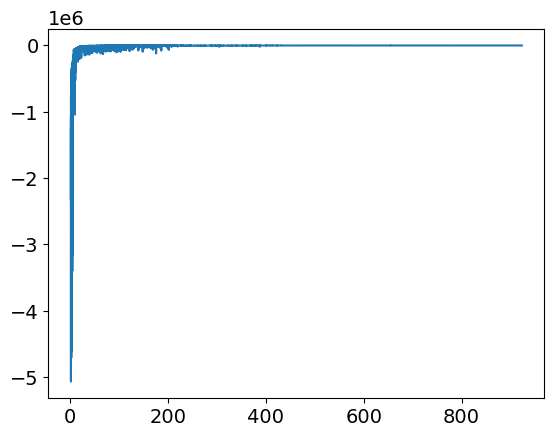

In [110]:
# ELBO
plt.plot(time_array[50:], -loss_array[50:])
plt.show()

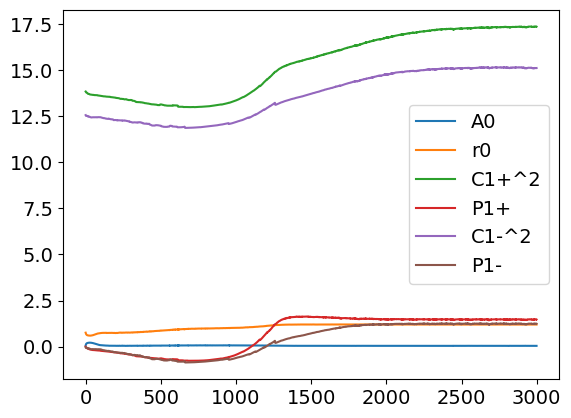

In [111]:
# means
plt.plot(np.array(param_dictionary["q_theta_m"])[:,0,:6])
plt.legend(names)
plt.show()

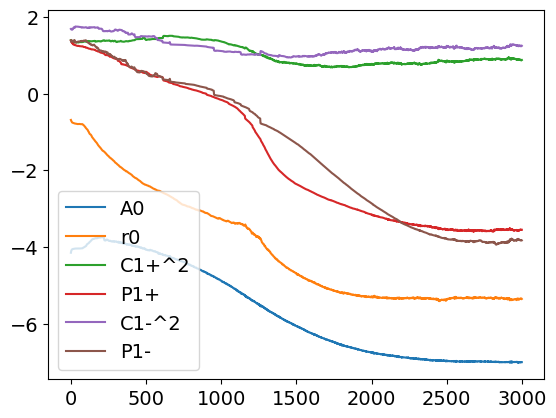

In [112]:
# SD
plt.plot(np.array(param_dictionary["q_theta_s"])[:,0,:6])
plt.legend(names)
plt.show()

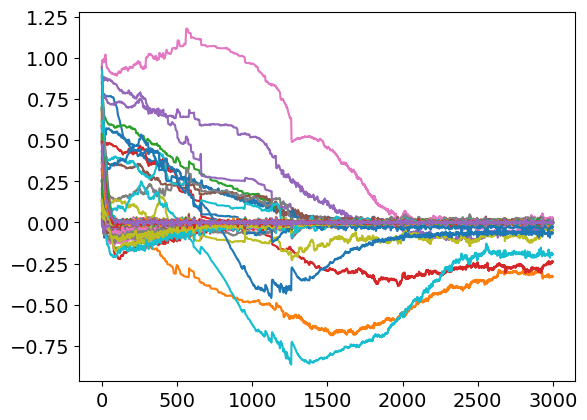

In [113]:
# Cholesky factor components for covariance matrix
plt.plot(np.array(param_dictionary["q_theta_c"])[:,0,:])
plt.show()

### Correlations

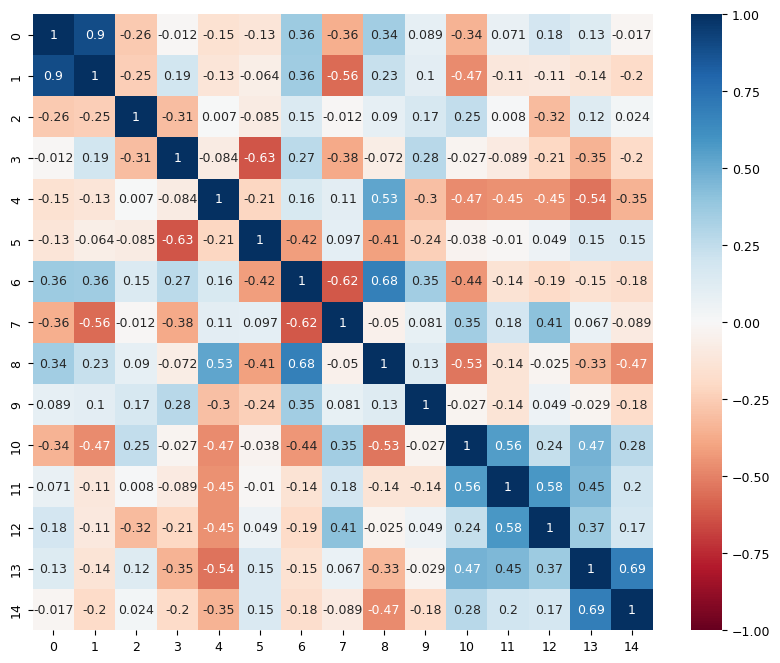

In [33]:
# All parameters
L = model.cholesky_factor()
S = L @ L.T
plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': 9})
cmap = "RdBu"
sns.heatmap(np.around(correlation_from_covariance(S.detach().numpy()), decimals = 3), vmin=-1, vmax=1, annot=True, cmap = cmap)
plt.show()

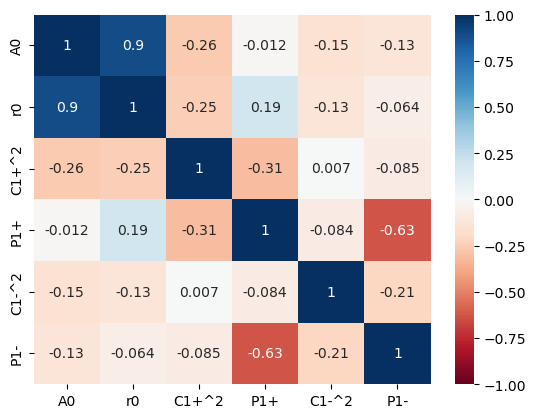

In [34]:
# Calibration parameters only
plt.rcParams.update({'font.size': 10})
cmap = "RdBu"
sns.heatmap(pd.DataFrame(np.around(correlation_from_covariance(S.detach().numpy()), decimals = 3)[:6,:6], columns = names, index = names), vmin=-1, vmax=1, annot=True, cmap=cmap)
plt.show()

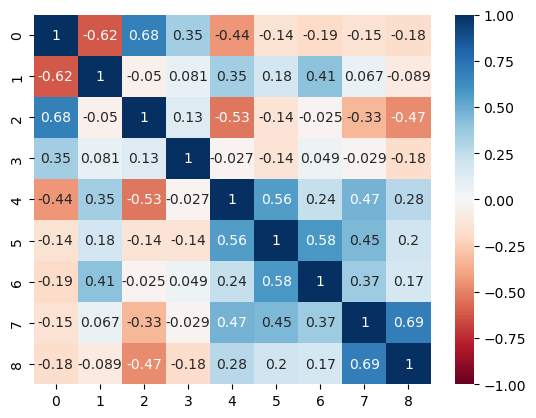

In [35]:
# Normalizing factors only
plt.rcParams.update({'font.size': 10})
cmap = "RdBu"
sns.heatmap(np.around(correlation_from_covariance(S.detach().numpy()), decimals = 3)[6:,6:], vmin=-1, vmax=1, annot=True, cmap = cmap)
plt.show()

### Posteriors

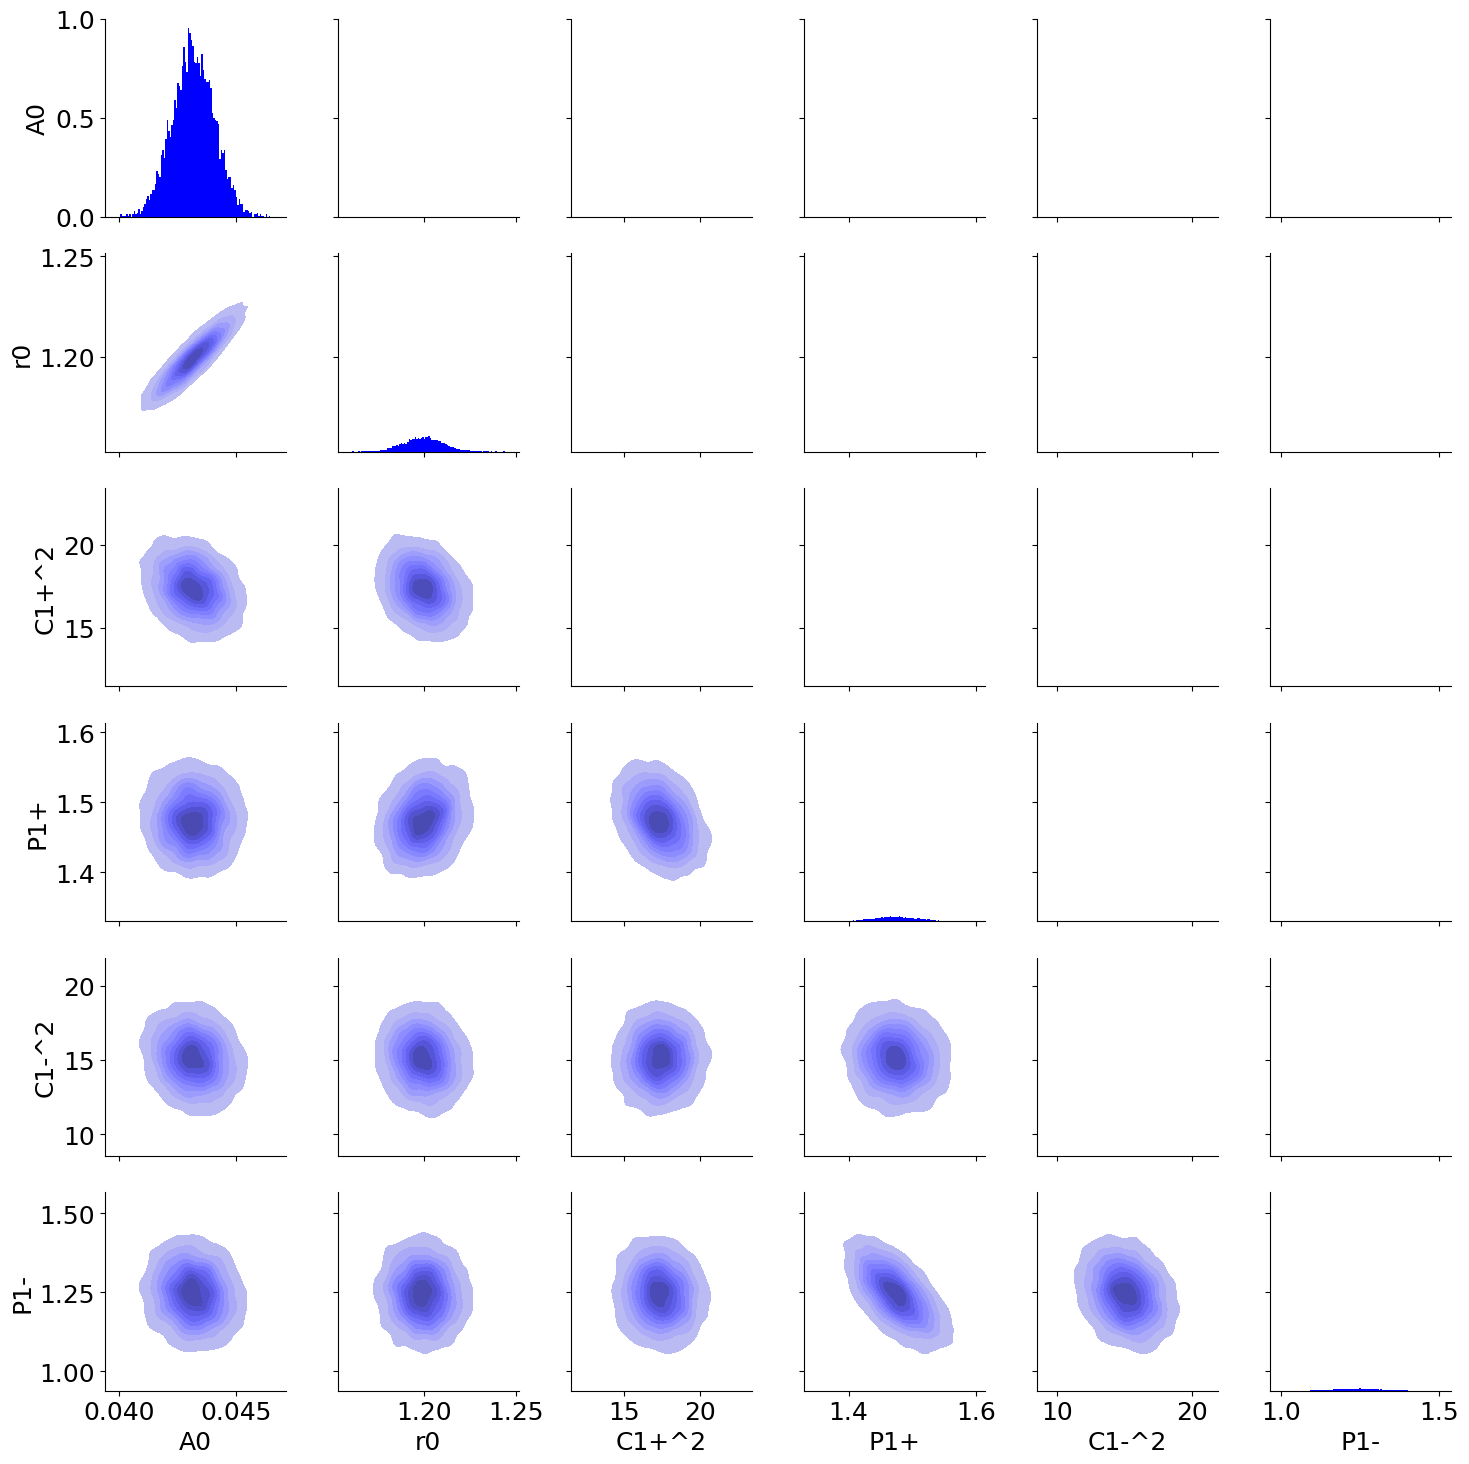

In [40]:
# VI Psoteriors
model.nMC = 5000
L = model.cholesky_factor()
z = model.generate_sample(n_var = model.param_dim + model.f_dim)
theta = model.sample_reparam_normal(z, model.q_theta_m, L)   

alpha = 1
bins = 100
plt.rcParams.update({'font.size': 18})
samples = pd.DataFrame(theta.detach().numpy().reshape(model.nMC, model.param_dim +model.f_dim)[:,:6], columns = names)
g = sns.PairGrid(samples)
g.map_diag(plt.hist, bins = bins, alpha = alpha, color = "blue", density= True)
g.map_lower(sns.kdeplot, shade= True, thresh=0.05, color = "blue")
plt.show()

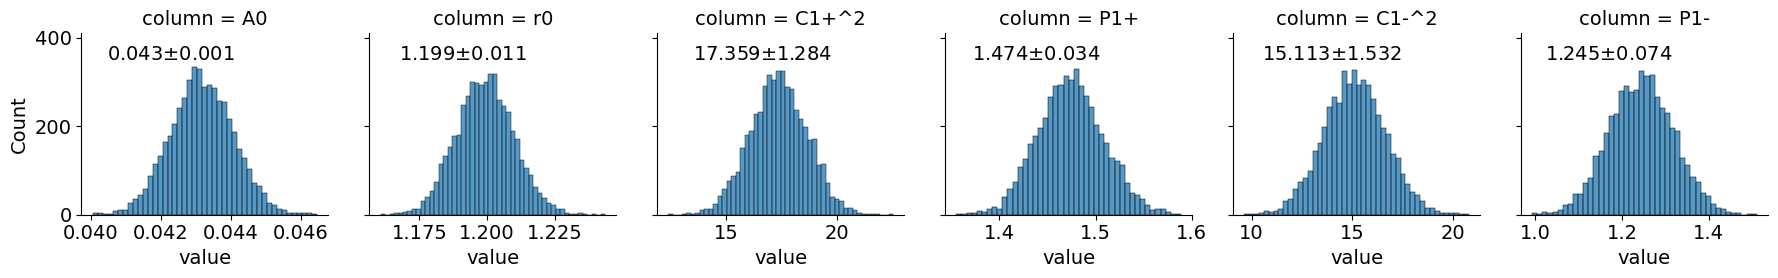

In [114]:
samples_melted = samples.melt(var_name='column')
plt.rcParams.update({'font.size': 14})
g = sns.FacetGrid(samples_melted, col='column', sharex=False)
g.map(specs, 'value', top  = 350)
plt.show()

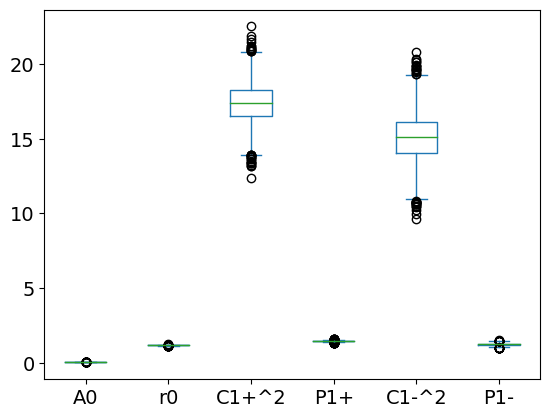

In [42]:
samples.plot(kind = "box")
plt.show()